In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_12_var_avg_new'

In [4]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 2
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [5]:
def dataset_file_name(file_name):
    name = "./dataset/"+str(file_name)
    if FILT != 0:
        name+="_FILTER_"+str(FILTER)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)+"_DERIVATIVE_"+str(DERIVATIVE)
    return name

In [6]:
DATASET_FILE_NAME = dataset_file_name(file_name)
X_train_file = DATASET_FILE_NAME+"_train_dataset.npy"
y_train_file = DATASET_FILE_NAME+"_train_dataset_label.npy"
X_test_file = DATASET_FILE_NAME+"_test_dataset.npy"
y_test_file = DATASET_FILE_NAME+"_test_dataset_label.npy"

In [7]:
X_train =  np.load(X_train_file)
y_train =  np.load(y_train_file)
X_test  =  np.load(X_test_file)
y_test  =  np.load(y_test_file)

In [8]:
y_set = set(y_train)

In [9]:
NUM_OF_CLASSES = len(y_set)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(19353, 147, 1)
(4839, 147, 1)


In [11]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D, Dropout

In [12]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape,activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Conv1D(filters=64, kernel_size=5, activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [13]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0

In [15]:
train_eva = []
test_eva = []

In [16]:
history_dataframe = pd.DataFrame() 

In [17]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
152/152 - 7s - loss: 1.3867 - accuracy: 0.2523 - 7s/epoch - 43ms/step
for training
605/605 [==============================] - 4s 5ms/step - loss: 1.3864 - accuracy: 0.2511
for testing
152/152 [==============================] - 1s 6ms/step - loss: 1.3865 - accuracy: 0.2455

Epoch:  2
152/152 - 5s - loss: 1.3856 - accuracy: 0.2591 - 5s/epoch - 34ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 1.3689 - accuracy: 0.2747
for testing
152/152 [==============================] - 1s 6ms/step - loss: 1.3712 - accuracy: 0.2724

Epoch:  3
152/152 - 5s - loss: 1.3472 - accuracy: 0.3254 - 5s/epoch - 36ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 1.2905 - accuracy: 0.3938
for testing
152/152 [==============================] - 1s 6ms/step - loss: 1.2869 - accuracy: 0.4030

Epoch:  4
152/152 - 5s - loss: 1.3007 - accuracy: 0.3721 - 5s/epoch - 34ms/step
for training
605/605 [==============================] - 3s 6ms/step

605/605 [==============================] - 3s 5ms/step - loss: 0.1995 - accuracy: 0.9312
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.1992 - accuracy: 0.9316

Epoch:  59
152/152 - 5s - loss: 0.3413 - accuracy: 0.8637 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.2484 - accuracy: 0.9067
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.2483 - accuracy: 0.9051

Epoch:  60
152/152 - 5s - loss: 0.3384 - accuracy: 0.8685 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.2683 - accuracy: 0.8919
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8954

Epoch:  61
152/152 - 5s - loss: 0.3556 - accuracy: 0.8590 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.2696 - accuracy: 0.8957
for testing
152/152 [==============================] - 1

for training
605/605 [==============================] - 3s 6ms/step - loss: 0.2039 - accuracy: 0.9173
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9153

Epoch:  88
152/152 - 5s - loss: 0.2967 - accuracy: 0.8818 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 6ms/step - loss: 0.2186 - accuracy: 0.9118
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.2240 - accuracy: 0.9099

Epoch:  89
152/152 - 5s - loss: 0.2976 - accuracy: 0.8828 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.1859 - accuracy: 0.9286
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9268

Epoch:  90
152/152 - 5s - loss: 0.2870 - accuracy: 0.8881 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 6ms/step - loss: 0.1592 - accuracy: 0.9430
for testing
152/152 [======================

605/605 [==============================] - 3s 6ms/step - loss: 0.1579 - accuracy: 0.9381
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1657 - accuracy: 0.9351

Epoch:  145
152/152 - 5s - loss: 0.2403 - accuracy: 0.9053 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 6ms/step - loss: 0.1363 - accuracy: 0.9522
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1438 - accuracy: 0.9481

Epoch:  146
152/152 - 5s - loss: 0.2414 - accuracy: 0.9056 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 3s 6ms/step - loss: 0.1217 - accuracy: 0.9561
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1322 - accuracy: 0.9487

Epoch:  147
152/152 - 5s - loss: 0.2239 - accuracy: 0.9129 - 5s/epoch - 35ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.1292 - accuracy: 0.9534
for testing
152/152 [==============================] 

605/605 [==============================] - 4s 6ms/step - loss: 0.0998 - accuracy: 0.9633
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1155 - accuracy: 0.9570

Epoch:  202
152/152 - 6s - loss: 0.1963 - accuracy: 0.9241 - 6s/epoch - 37ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0989 - accuracy: 0.9652
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1148 - accuracy: 0.9562

Epoch:  203
152/152 - 5s - loss: 0.1959 - accuracy: 0.9255 - 5s/epoch - 36ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.1521 - accuracy: 0.9396
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1686 - accuracy: 0.9392

Epoch:  204
152/152 - 5s - loss: 0.2168 - accuracy: 0.9165 - 5s/epoch - 36ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.1057 - accuracy: 0.9639
for testing
152/152 [==============================] 

605/605 [==============================] - 4s 6ms/step - loss: 0.0845 - accuracy: 0.9686
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1037 - accuracy: 0.9599

Epoch:  259
152/152 - 6s - loss: 0.1756 - accuracy: 0.9312 - 6s/epoch - 37ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0996 - accuracy: 0.9670
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1248 - accuracy: 0.9552

Epoch:  260
152/152 - 6s - loss: 0.1666 - accuracy: 0.9359 - 6s/epoch - 37ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0794 - accuracy: 0.9721
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0986 - accuracy: 0.9607

Epoch:  261
152/152 - 6s - loss: 0.1797 - accuracy: 0.9304 - 6s/epoch - 37ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0818 - accuracy: 0.9705
for testing
152/152 [==============================] 

605/605 [==============================] - 4s 6ms/step - loss: 0.1015 - accuracy: 0.9602
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.1213 - accuracy: 0.9539

Epoch:  316
152/152 - 6s - loss: 0.1651 - accuracy: 0.9375 - 6s/epoch - 38ms/step
for training
605/605 [==============================] - 4s 7ms/step - loss: 0.0760 - accuracy: 0.9730
for testing
152/152 [==============================] - 1s 7ms/step - loss: 0.0973 - accuracy: 0.9624

Epoch:  317
152/152 - 6s - loss: 0.1524 - accuracy: 0.9427 - 6s/epoch - 42ms/step
for training
605/605 [==============================] - 4s 7ms/step - loss: 0.0715 - accuracy: 0.9751
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0941 - accuracy: 0.9649

Epoch:  318
152/152 - 6s - loss: 0.1561 - accuracy: 0.9385 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0785 - accuracy: 0.9701
for testing
152/152 [==============================] 

605/605 [==============================] - 4s 6ms/step - loss: 0.0660 - accuracy: 0.9781
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0926 - accuracy: 0.9663

Epoch:  373
152/152 - 6s - loss: 0.1477 - accuracy: 0.9447 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0672 - accuracy: 0.9763
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0959 - accuracy: 0.9611

Epoch:  374
152/152 - 6s - loss: 0.1411 - accuracy: 0.9462 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0590 - accuracy: 0.9794
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0843 - accuracy: 0.9688

Epoch:  375
152/152 - 6s - loss: 0.1391 - accuracy: 0.9476 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0738 - accuracy: 0.9730
for testing
152/152 [==============================] 

In [18]:
history_dataframe

,loss,accuracy
0,1.386653,0.252261
1,1.385624,0.259081
2,1.347169,0.325376
3,1.300652,0.372087
4,1.270555,0.393479
...,...,...
395,0.135096,0.948173
396,0.135956,0.949000
397,0.128685,0.951377
398,0.134729,0.949000


In [19]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [20]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

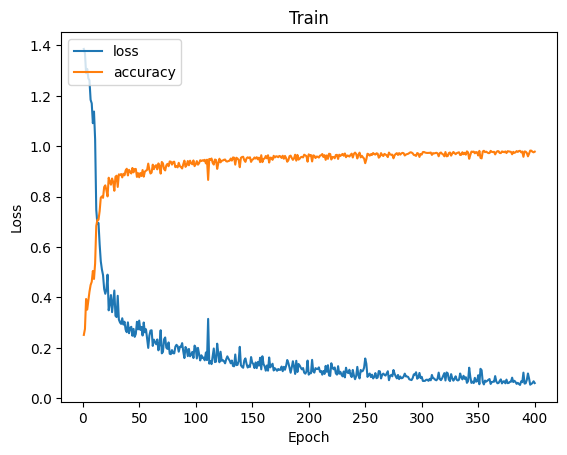

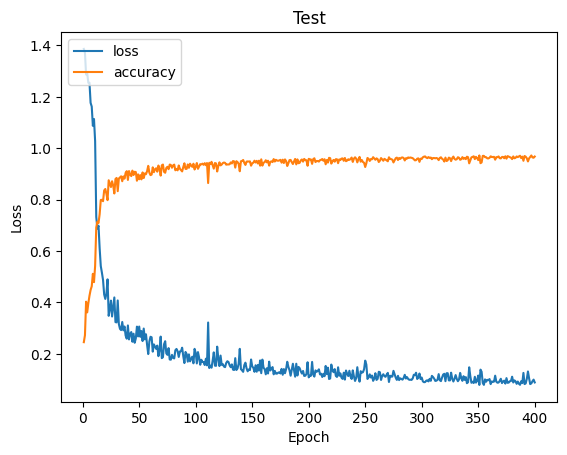

In [21]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [22]:
train_eva_df['accuracy'].max()

0.9828450083732605

In [23]:
train_eva_df.idxmax()

loss          0
accuracy    395
dtype: int64

In [24]:
test_eva_df['accuracy'].max()

0.9721016883850098

In [25]:
test_eva_df.idxmax()

loss          0
accuracy    350
dtype: int64

In [ ]:
for x in range(400,600):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  401
152/152 - 6s - loss: 0.1429 - accuracy: 0.9479 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0648 - accuracy: 0.9785
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0982 - accuracy: 0.9657

Epoch:  402
152/152 - 6s - loss: 0.1342 - accuracy: 0.9476 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0695 - accuracy: 0.9758
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0992 - accuracy: 0.9640

Epoch:  403
152/152 - 6s - loss: 0.1334 - accuracy: 0.9517 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0637 - accuracy: 0.9765
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0936 - accuracy: 0.9651

Epoch:  404
152/152 - 6s - loss: 0.1300 - accuracy: 0.9498 - 6s/epoch - 39ms/step
for training
605/605 [==============================] - 4s 

for testing
152/152 [==============================] - 1s 7ms/step - loss: 0.0774 - accuracy: 0.9709

Epoch:  430
152/152 - 6s - loss: 0.1210 - accuracy: 0.9546 - 6s/epoch - 40ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0607 - accuracy: 0.9782
for testing
152/152 [==============================] - 1s 7ms/step - loss: 0.0927 - accuracy: 0.9647

Epoch:  431
152/152 - 6s - loss: 0.1297 - accuracy: 0.9514 - 6s/epoch - 40ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0508 - accuracy: 0.9832
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0790 - accuracy: 0.9684

Epoch:  432
152/152 - 6s - loss: 0.1201 - accuracy: 0.9530 - 6s/epoch - 40ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0652 - accuracy: 0.9762
for testing
152/152 [==============================] - 1s 7ms/step - loss: 0.0917 - accuracy: 0.9645

Epoch:  433
152/152 - 6s - loss: 0.1341 

In [ ]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [ ]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [ ]:
train_eva_df['accuracy'].max()

In [ ]:
train_eva_df.idxmax()

In [ ]:
test_eva_df['accuracy'].max()

In [ ]:
test_eva_df.idxmax()